In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from objectives import *
from plots import *
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
from torchvision import datasets, transforms
import probtorch
from probtorch.util import expand_inputs

print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [27]:
T = 50
D = 2
NUM_PIXELS = 32*32
pixels=32
## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 256
NUM_LATENT = 2
NUM_OBS = NUM_PIXELS
BATCH_SIZE = T
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
EPS = 1e-9
CUDA = torch.cuda.is_available()

ALPHA = 0.1
BETA = (2.0, 2.0, 1.0, 0.0, 1.0) 

In [28]:
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_latent=NUM_LATENT):
        super(self.__class__, self).__init__()

        self.enc_hidden = nn.Sequential( 
                            nn.Linear(num_pixels, num_hidden),
                            nn.ReLU(),
                            nn.Linear(num_hidden, num_hidden),
                            nn.ReLU())
        
        self.z_mean = nn.Linear(num_hidden, num_latent)
        self.z_log_std = nn.Linear(num_hidden, num_latent)
    @expand_inputs
    def forward(self, images, labels=None, num_samples=NUM_SAMPLES):
        q = probtorch.Trace()
        hiddens = self.enc_hidden(images)
        q.normal(self.z_mean(hiddens),
                 self.z_log_std(hiddens).exp(),
                 name='z')
        return q
    
def binary_cross_entropy(x_mean, x, EPS=1e-9):
    return - (torch.log(x_mean + EPS) * x + 
              torch.log(1 - x_mean + EPS) * (1 - x)).sum(-1)

class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_latent=NUM_LATENT):
        super(self.__class__, self).__init__()
        
        self.dec_image = nn.Sequential(
                           nn.Linear(num_latent, num_hidden),
                           nn.ReLU(),
                           nn.Linear(num_hidden, num_pixels),
                           nn.Sigmoid())

    def forward(self, images, q=None, num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE, num_latent=NUM_LATENT):
        p = probtorch.Trace()
        z_mean = torch.zeros(num_samples, batch_size, num_latent)
        z_std = torch.ones(num_samples, batch_size, num_latent)
        
        if CUDA:
            z_mean = z_mean.cuda()
            z_std = z_std.cuda()
        
        z = p.normal(z_mean, 
                     z_std,
                     value=q['z'],
                     name='z')
        
        images_mean = self.dec_image(z)
        p.loss(binary_cross_entropy, images_mean, images, name='images')
        
        return p

In [29]:
def elbo(q, p, alpha=ALPHA, beta=BETA, bias=1.0):
    return probtorch.objectives.marginal.elbo(q, p, sample_dim=0, batch_dim=1,
                                              alpha=alpha, beta=beta, bias=bias)

enc = Encoder()
dec = Decoder()
if CUDA:
    enc.cuda()
    dec.cuda()

optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                              lr=LEARNING_RATE)

In [30]:
pixels_path = '/home/hao/Research/amortized/AmortizedGibbs/batch_training/images/'
ToGrayscaleTensor = transforms.Compose([transforms.Grayscale(), transforms.Resize(pixels), transforms.ToTensor()])
train_data = datasets.ImageFolder(root = pixels_path, transform=ToGrayscaleTensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)

In [31]:
enc.train()
dec.train()

for epoch in range(NUM_EPOCHS):
    train_start = time.time()
    epoch_elbo = 0.0
    N = 0.0
    for b, (images, labels) in enumerate(train_loader):
        if images.size()[0] == BATCH_SIZE:
            N += BATCH_SIZE
            images = images.view(-1, NUM_PIXELS)
            images = torch.where(images == 1.0, torch.FloatTensor([0.0]), torch.FloatTensor([1.0]))
            if CUDA:
                images = images.cuda()
            optimizer.zero_grad()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE)
            loss = -elbo(q, p)
            loss.backward()
            optimizer.step()
            if CUDA:
                loss = loss.cpu()
            epoch_elbo -= float(loss.item())
    epoch_elbo = epoch_elbo / N
    train_end = time.time()
    print('[Epoch %d] Train: ELBO %.4e (%ds)' % (epoch, epoch_elbo, train_end - train_start))
        

[Epoch 0] Train: ELBO -3.9619e+00 (4s)
[Epoch 1] Train: ELBO -2.5422e+00 (4s)
[Epoch 2] Train: ELBO -2.4678e+00 (4s)
[Epoch 3] Train: ELBO -2.0009e+00 (4s)
[Epoch 4] Train: ELBO -1.6914e+00 (4s)
[Epoch 5] Train: ELBO -1.5457e+00 (3s)
[Epoch 6] Train: ELBO -1.4481e+00 (3s)
[Epoch 7] Train: ELBO -1.3743e+00 (3s)
[Epoch 8] Train: ELBO -1.3158e+00 (3s)
[Epoch 9] Train: ELBO -1.2651e+00 (3s)
[Epoch 10] Train: ELBO -1.2256e+00 (3s)
[Epoch 11] Train: ELBO -1.1890e+00 (3s)
[Epoch 12] Train: ELBO -1.1562e+00 (3s)
[Epoch 13] Train: ELBO -1.1272e+00 (3s)
[Epoch 14] Train: ELBO -1.0994e+00 (3s)
[Epoch 15] Train: ELBO -1.0763e+00 (3s)
[Epoch 16] Train: ELBO -1.0552e+00 (3s)
[Epoch 17] Train: ELBO -1.0357e+00 (3s)
[Epoch 18] Train: ELBO -1.0153e+00 (3s)
[Epoch 19] Train: ELBO -9.9740e-01 (3s)
[Epoch 20] Train: ELBO -9.8265e-01 (3s)
[Epoch 21] Train: ELBO -9.6566e-01 (3s)
[Epoch 22] Train: ELBO -9.5023e-01 (3s)
[Epoch 23] Train: ELBO -9.3585e-01 (3s)
[Epoch 24] Train: ELBO -9.2341e-01 (3s)
[Epoch 25]

In [ ]:
def load_test(STATE, Boundary, pixels, dpi, radius, 0):
    length_states = 51
    for s in range(length_states):
        np.load()
        plt.savefig('images/%s-%s.png' % (str(seq_ind), str(s)),dpi=dpi)
        plt.close()

In [36]:
from scipy import misc
a = misc.imread('images/0-3.png')

/home/hao/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


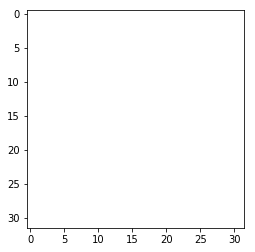

In [42]:
plt.imshow(a[:, :, -1],  cmap='gray', vmin=0.0, vmax=1.0)